# Image classification with Vision Transformer

**Original Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>

**Modified by:** [Yash Garje]<br>

**Description:** Implementing the Vision Transformer (ViT) model for image classification.

This script has been modified to suit the Mayo Clinic's - Strip AI blood clot image classificaiton task.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.8 MB/s 


## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import glob
import cv2

In [ ]:
# Read the training data CSV file into a dataframe
# df is the training data csv
df = pd.read_csv(r'/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_training_data.csv')
labels = pd.read_csv(r'/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_training_labels.csv')
df['label'] = labels

# Convert the labels into binary values for easy computation
df['binary_label'] = np.where(df['label']== 'CE', 0, 1)  #CE is 0, LAA is 1
# df.head()

## Prepare the data

In [ ]:
# Since this is a binary classification, num_classes =2
num_classes = 2
# Denotes the size of the input image
sz = 100


input_shape = (sz, sz, 3)

# Assign testing data csv and testing label
testdf = pd.read_csv(r'/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_testing_data.csv')
testlabel = pd.read_csv(r'/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_testing_labels.csv')
testdf['label'] = testlabel

# Convert the labels into binary values for easy computation
testdf['binary_label'] = np.where(testdf['label']== 'CE', 0, 1)
# testdf.head()

In [ ]:
# We are resizing the images and creating train_datagen, test_datagen
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(dataframe=df, directory ='/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_train',
                                                    x_col='image_id', y_col='label',
                                                    target_size=(sz, sz),batch_size=32,shuffle=True,class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(dataframe = testdf, directory= '/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_test',
                                                  x_col = 'image_id', y_col = 'label',
                                                  target_size=(sz,sz),batch_size=32,shuffle=False,class_mode='binary')

x_train =np.array([cv2.resize(cv2.imread(file),(sz,sz),interpolation = cv2.INTER_AREA) for file in glob.glob(r'/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_train/*.jpg')])
x_test = np.array([cv2.resize(cv2.imread(file),(sz,sz),interpolation = cv2.INTER_AREA) for file in glob.glob(r'/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_test_2/*.jpg')])

y_train = labels
y_test = testlabel

#  Print out the size of the training and testing datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


Found 2085 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
x_train shape: (2085, 100, 100, 3) - y_train shape: (2085, 1)
x_test shape: (522, 100, 100, 3) - y_test shape: (522, 1)


In [ ]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (2085, 100, 100, 3) - y_train shape: (2085,)
x_test shape: (522, 100, 100, 3) - y_test shape: (522,)


## Configure the hyperparameters

In [ ]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 32 #256
num_epochs = 50
image_size = sz  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 100 X 100
Patch size: 6 X 6
Patches per image: 256
Elements per patch: 108


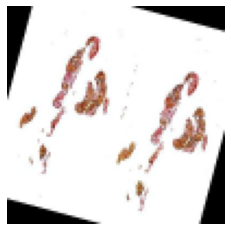

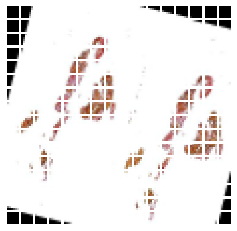

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    print(inputs)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:
from keras import backend as K




def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

from tensorflow.python import metrics

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

  #   model.compile(
  #       optimizer=optimizer,
  #     #  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  #       # loss = keras.losses.BinaryCrossentropy(from_logits=False),
  #       loss = tf.keras.losses.binary_crossentropy,
  #       # metrics=['accuracy']
  #       # metrics =[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
  #           # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
  #           # keras.metrics.AUC(name ="AUC")
  #       #  ],
  #       metrics =['acc',f1_m,precision_m, recall_m] 
  #   )
  # # opt = SGD(learning_rate=1e-6, momentum=0.9)
  # # model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=opt,metrics=['accuracy'])

  #   # metric = 'val_accuracy'
  #   # ModelCheckpoint(filepath=r"C:\Users\reda.elhail\Desktop\checkpoints\{}".format(Name), monitor=metric,
  #   #                     verbose=2, save_best_only=True, mode='max')]

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )


    checkpoint_filepath = r'/content/drive/MyDrive/Machine Learning project/train/tmp/checkpoint'
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

    # model.load_weights(checkpoint_filepath)
    # # loss, accuracy = model.evaluate(x_test, y_test)
    
    # # _, accuracy, top_5_accuracy,AUC = model.evaluate(x_test, y_test)
    # loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    # # print(f"AUC: {round(AUC)}%")
    # # print(f"Loss is : {round(loss)}")

    # return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Epoch 1/50
59/59 [==============================] - 21s 191ms/step - loss: 1.7855 - accuracy: 0.4931 - top-5-accuracy: 1.0000 - val_loss: 1.2382 - val_accuracy: 0.5359 - val_top-5-accuracy: 1.0000
Epoch 2/50
59/59 [==============================] - 8s 141ms/step - loss: 1.4039 - accuracy: 0.4963 - top-5-accuracy: 1.0000 - val_loss: 1.0009 - val_accuracy: 0.4737 - val_top-5-accuracy: 1.0000
Epoch 3/50
59/59 [==============================] - 10s 177ms/step - loss: 1.1926 - accuracy: 0.4904 - top-5-accuracy: 1.0000 - val_loss: 0.8159 - val_accuracy: 0.5455 - val_top-5-accuracy: 1.0000
Epoch 4/50
59/59 [==============================] - 8s 137ms/step - loss: 1.1042 - accuracy: 0.4952 - top-5-accuracy: 1.0000 - val_loss: 0.7852 - val_accuracy: 0.5407 - val_top-5-accuracy: 1.0000
Epoch 5/50
59/59 [==============================] - 9s 146ms/

In [ ]:
history.history

{'loss': [1.7855262756347656,
  1.4039055109024048,
  1.1926227807998657,
  1.1041500568389893,
  0.9991512298583984,
  0.8920875787734985,
  0.8833337426185608,
  0.8556935787200928,
  0.8100766539573669,
  0.8027847409248352,
  0.7995361089706421,
  0.7686086297035217,
  0.7546064257621765,
  0.7426345348358154,
  0.7482704520225525,
  0.7320044636726379,
  0.7309447526931763,
  0.7280310392379761,
  0.7334381937980652,
  0.7179905772209167,
  0.728399395942688,
  0.7252001762390137,
  0.7276908159255981,
  0.7131512761116028,
  0.7003740668296814,
  0.7041884064674377,
  0.7143403887748718,
  0.7135942578315735,
  0.7101238965988159,
  0.7071268558502197,
  0.7051318287849426,
  0.7035748362541199,
  0.7006216049194336,
  0.7086676955223083,
  0.6988357901573181,
  0.6965423226356506,
  0.6925003528594971,
  0.6953541040420532,
  0.6957128643989563,
  0.6983405947685242,
  0.6963859796524048,
  0.6957527995109558,
  0.6943631768226624,
  0.6936076283454895,
  0.695411741733551,
  0.

In [ ]:
# 72x72 --> 10 epochs --> 54.02% accuracy
# 400x400  --> crash
# 200x200  --> out of memory
# 100x 100 --> 10 epoch --> 52.87%  accuracy

#Start time 22:40

model=vit_classifier
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 100, 100, 3)  7          ['input_21[0][0]']               
                                                                                                  
 patches_22 (Patches)           (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_20 (PatchEncoder  (None, 256, 64)     23360       ['patches_22[0][0]']      

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.

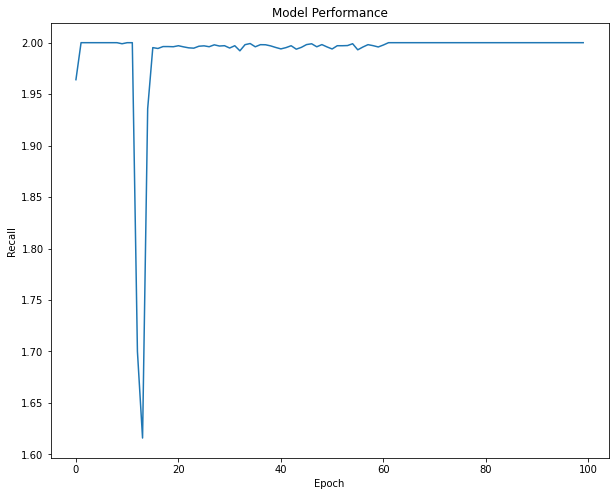

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(history.history['recall_m'])
# plt.plot(history.history['precision_m'])
plt.title('Model Performance')
plt.ylabel('Recall')
plt.xlabel('Epoch')
# plt.legend(['Recall','Precision'])
plt.show()

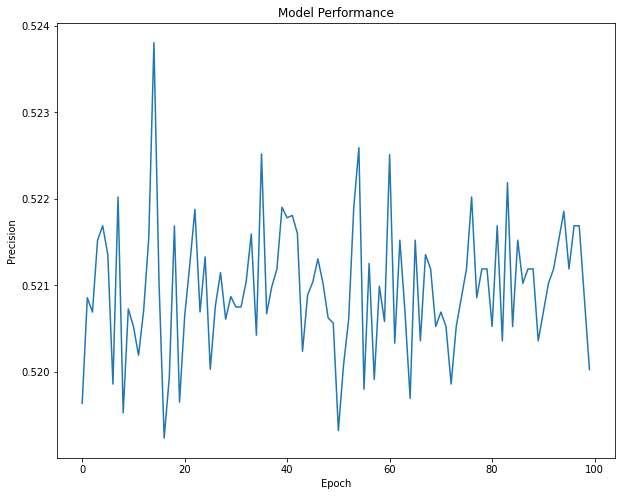

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
# plt.plot(history.history['recall_m'])
plt.plot(history.history['precision_m'])
plt.title('Model Performance')
plt.ylabel('Precision')
plt.xlabel('Epoch')
# plt.legend(['Recall','Precision'])
plt.show()

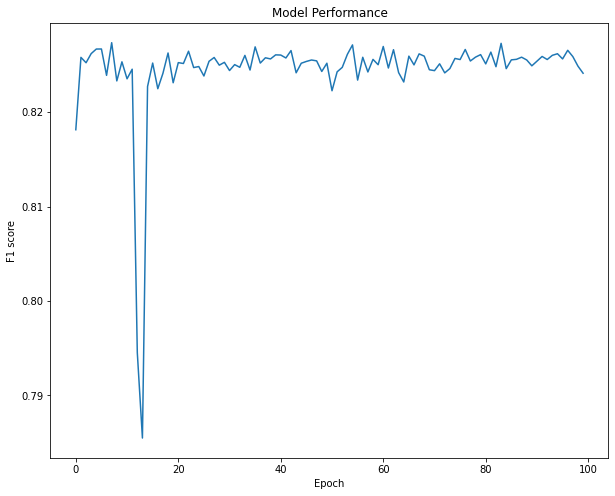

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(history.history['f1_m'])
plt.title('Model Performance')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
# plt.legend(['Recall','Precision'])
plt.show()

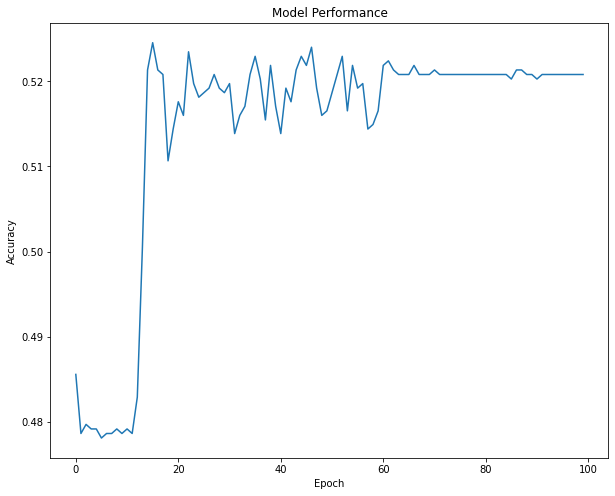

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(history.history['acc'])
# plt.plot(history.history['precision_m'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend(['Recall','Precision'])
plt.show()

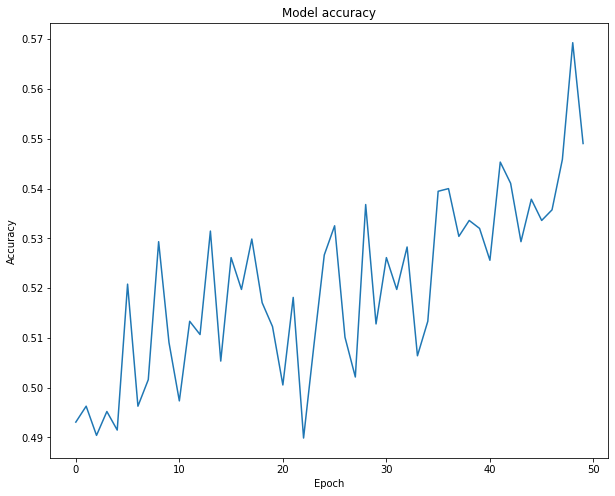

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(history.history['accuracy'])
# plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend(['Recall','Precision'])
plt.show()

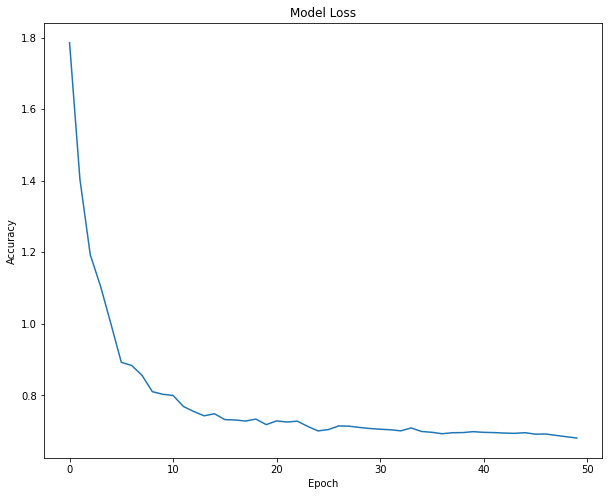

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
# plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend(['Recall','Precision'])
plt.show()